In [1]:
# Bike-sharing Data Analytics Project

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
import altair as alt
import folium

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
# 1. Description of the Available Data
logger.info("Loading and describing the available data")

# Load the data (you'll need to modify the data_loader.py script)
from data_loader import load_sample_data, preprocess_data

stations_info, status_data = load_sample_data()
if stations_info is None or status_data is None:
    logger.error("Failed to load sample data")
else:
    merged_data = preprocess_data(stations_info, status_data)
    
    print("Data shape:", merged_data.shape)
    print("\nColumns:", merged_data.columns)
    print("\nData types:\n", merged_data.dtypes)
    print("\nSummary statistics:\n", merged_data.describe())

2024-10-24 15:26:55,390 - INFO - Loading and describing the available data
2024-10-24 15:26:55,543 - INFO - Successfully connected to MongoDB
2024-10-24 15:26:55,553 - INFO - Loaded 516 stations
2024-10-24 15:26:55,554 - INFO - Attempting to load status data for one day in September 2024
2024-10-24 15:27:33,183 - INFO - Loaded 146930 status records
2024-10-24 15:27:33,569 - INFO - Successfully loaded and sampled data for one day in September 2024
2024-10-24 15:27:33,573 - INFO - Starting data preprocessing
2024-10-24 15:27:33,611 - INFO - Merged data shape: (14693, 12)
2024-10-24 15:27:33,618 - INFO - Data shape after filtering non-existent stations: (14693, 12)
2024-10-24 15:27:33,628 - INFO - Data preprocessing completed


Data shape: (14693, 15)

Columns: Index(['_id_x', 'station_id', 'num_bikes_available', 'num_docks_available',
       'last_reported', '_id_y', 'altitude', 'cross_street', 'lat', 'lon',
       'name', 'post_code', 'hour', 'day_of_week', 'is_weekend'],
      dtype='object')

Data types:
 _id_x                          object
station_id                      int64
num_bikes_available             int64
num_docks_available             int64
last_reported          datetime64[ns]
_id_y                          object
altitude                      float64
cross_street                   object
lat                           float64
lon                           float64
name                           object
post_code                      object
hour                            int32
day_of_week                     int32
is_weekend                      int64
dtype: object

Summary statistics:
          station_id  num_bikes_available  num_docks_available  \
count  14693.000000         14693.000000  

In [3]:
# 2. Problem Type
logger.info("Defining the problem type")

print("This is a regression problem. We aim to predict the number of available bikes at a given station and time.")
print("Response variable: num_bikes_available")

2024-10-24 15:27:33,718 - INFO - Defining the problem type


This is a regression problem. We aim to predict the number of available bikes at a given station and time.
Response variable: num_bikes_available


In [6]:
# 3. Data Pre-processing
logger.info("Performing data pre-processing")

# Check for missing values
print("Missing values:\n", X.isnull().sum())

# Create a pipeline for preprocessing and model training
def create_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

2024-10-24 15:27:43,823 - INFO - Performing data pre-processing


Missing values:
 hour            0
day_of_week     0
lat             0
lon             0
altitude       52
dtype: int64


In [5]:
# 4. Validation Protocol
logger.info("Setting up validation protocol")

# Split the data into training and testing sets
X = merged_data[['hour', 'day_of_week', 'lat', 'lon', 'altitude']]
y = merged_data['num_bikes_available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

2024-10-24 15:27:41,364 - INFO - Setting up validation protocol


Training set shape: (11754, 5)
Testing set shape: (2939, 5)


In [7]:
# 5. Statistical or Machine Learning Techniques
logger.info("Applying machine learning techniques")

# Check for missing values
print("Missing values:\n", X.isnull().sum())

# Create a pipeline for preprocessing and model training
def create_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Function to train and evaluate a model
def train_and_evaluate(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return pipeline, mse, r2

# Linear Regression
lr_pipeline = create_pipeline(LinearRegression())
lr_model, lr_mse, lr_r2 = train_and_evaluate(lr_pipeline, X_train, X_test, y_train, y_test)

# Random Forest
rf_pipeline = create_pipeline(RandomForestRegressor(n_estimators=100, random_state=42))
rf_model, rf_mse, rf_r2 = train_and_evaluate(rf_pipeline, X_train, X_test, y_train, y_test)

# Neural Network
nn_pipeline = create_pipeline(MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=200, random_state=42))
nn_model, nn_mse, nn_r2 = train_and_evaluate(nn_pipeline, X_train, X_test, y_train, y_test)

# Time Series Analysis (ARIMA)
# For simplicity, we'll use a single station's data
station_id = merged_data['station_id'].iloc[0]
station_data = merged_data[merged_data['station_id'] == station_id].set_index('last_reported')['num_bikes_available']
station_data = station_data.resample('H').mean()

# Handle NaN values in the time series data
station_data = station_data.fillna(method='ffill').fillna(method='bfill')

# Fit ARIMA model
arima_model = ARIMA(station_data, order=(1, 1, 1))
arima_results = arima_model.fit()

2024-10-24 15:27:47,672 - INFO - Applying machine learning techniques


Missing values:
 hour            0
day_of_week     0
lat             0
lon             0
altitude       52
dtype: int64


c:\Users\danys\tfm\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\danys\AppData\Local\Temp\ipykernel_26812\735284207.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_data = station_data.resample('H').mean()
C:\Users\danys\AppData\Local\Temp\ipykernel_26812\735284207.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data = station_data.fillna(method='ffill').fillna(method='bfill')
c:\Users\danys\tfm\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\danys\tfm\env\Lib\si

2024-10-24 15:28:00,817 - INFO - Summarizing results and creating visualizations


Model Performance:
Linear Regression - MSE: 45.93, R2: 0.28
Random Forest - MSE: 6.92, R2: 0.89
Neural Network - MSE: 34.68, R2: 0.46


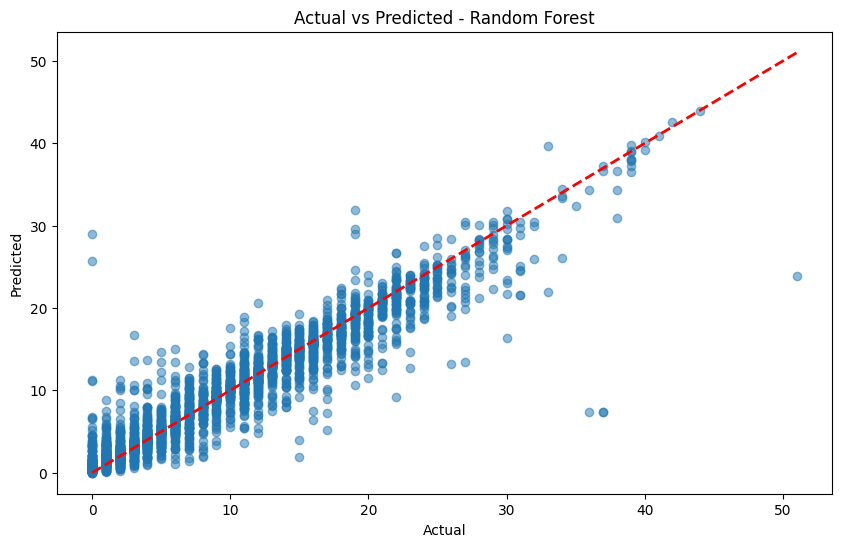

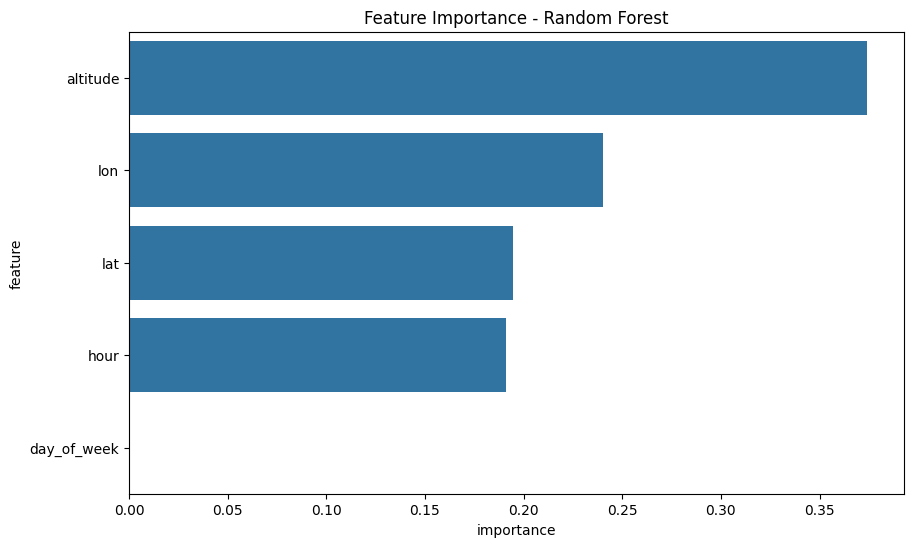

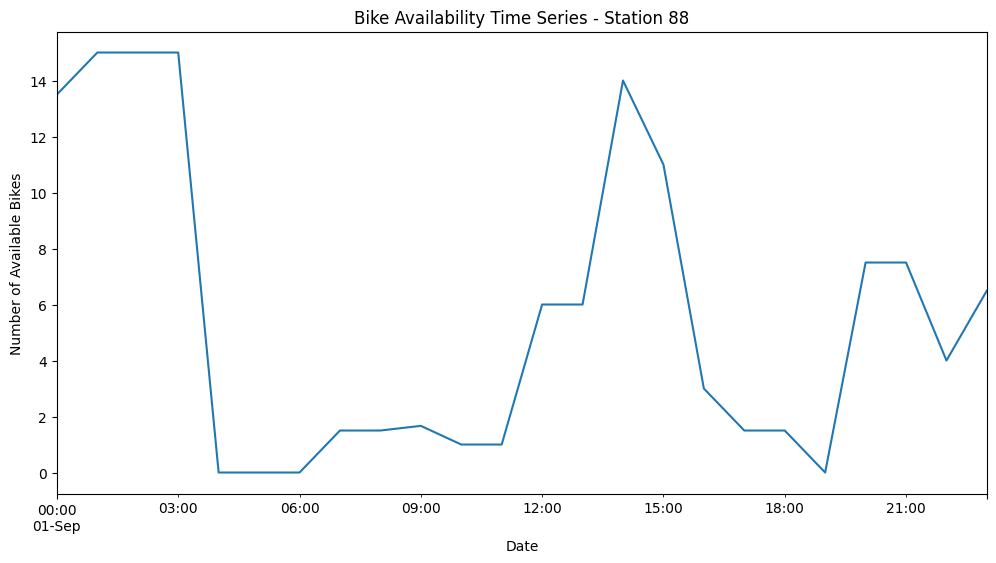

2024-10-24 15:28:02,230 - INFO - Analysis completed


Interactive station map saved as 'station_map.html'


In [8]:
# 6. Results Obtained and Discussion
logger.info("Summarizing results and creating visualizations")

print("Model Performance:")
print(f"Linear Regression - MSE: {lr_mse:.2f}, R2: {lr_r2:.2f}")
print(f"Random Forest - MSE: {rf_mse:.2f}, R2: {rf_r2:.2f}")
print(f"Neural Network - MSE: {nn_mse:.2f}, R2: {nn_r2:.2f}")

# Visualizations
# Actual vs Predicted plot for Random Forest (best performing model)
y_pred_rf = rf_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Random Forest")
plt.show()

# Feature Importance plot for Random Forest
rf_model_step = rf_model.named_steps['model']
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model_step.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title("Feature Importance - Random Forest")
plt.show()

# Time Series plot for a single station
plt.figure(figsize=(12, 6))
station_data.plot()
plt.title(f"Bike Availability Time Series - Station {station_id}")
plt.xlabel("Date")
plt.ylabel("Number of Available Bikes")
plt.show()

# Interactive map of stations
center_lat = stations_info['lat'].mean()
center_lon = stations_info['lon'].mean()
station_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for _, station in stations_info.iterrows():
    folium.Marker(
        location=[station['lat'], station['lon']],
        popup=f"Station ID: {station['station_id']}",
        tooltip=f"Station ID: {station['station_id']}"
    ).add_to(station_map)

station_map.save("station_map.html")
print("Interactive station map saved as 'station_map.html'")

logger.info("Analysis completed")